# QSIM [1] - What is qualitative simulation ?

Qualitative simulation (QSIM) and qualitative trend analysis (QTA) are two problems that have been on my mind since quite a while. Each come with their own tool set. I have done quite a bit of research on QTA. In contrast, I have not had a chance to really work with QSIM. This area of study is not so active these days but I think it deserves further and renewed attention. This post serves as an introduction to the topic. [The second post](qualitative-simulation-2.ipynb) will focus on a simple yet challenging problem for qualitative simulation techniques.

## Short background

Qualitative simulation (QSIM) is one of a few techniques to simulate qualitative behaviour of systems or processes [1-5]. The term *qualitative* takes on a very specific meaning here. Continuous variables are described very coarsely by means of open intervals and points marking the ends of these intervals. For example, one can coarsely describe the temperature $T$ to take on one of the following values: (a) below freezing point ($T<273.15K$), (b) at freezing point ($T=273.15K$), (c) between freezing point and boiling point ($273.15K<T<373.15K$), (d) at boiling point ($T=373.15K$), and (e) above boiling point ($T>373.15K$). 

A central idea to QSIM, and related methods, is that a coarse process description is sufficient to make sensible decisions to solve many practical problems. For example, the level of granularity as used above for temperature is sufficient to decide whether or not to add heat to a pot of water for the purpose of making pasta. In my own work, I have come across a number of problems where this kind of coarse description is the most detailed description that we can really trust. In those cases, the use of qualitative process descriptions, i.e. qualitative models, is both sufficient and necessary.

QSIM as a technique belongs to the broader field of *qualitative reasoning*. Depending on the authors and the specific study, computer-based qualitative reasoning can have some or all of the following goals:

* Explain or emulate how a typical adult or child thinks. This is also known as *naive physics* or *common-sense reasoning*.

* To explain fundamental concepts in a specific scientific domain to a pupil or student (see e.g., [[6]](https://doi.org/10.1609/aimag.v24i4.1729)). This could be considered a method for explainable artificial intelligence (explainable AI).

* To provide automated diagnostic results under uncertain circumstances, in the case of a rare fault or failure. The idea is that the predictions made with a qualitative model are more robust to extrapolation than a quantitative model.

Most often, only one of these goals is targeted. However, the same qualitative model could be used for all of these goals in principle. QSIM is not without its critics (see e.g., [[7]](https://doi.org/10.1111/j.1467-8640.1992.tb00344.x)). One issue is that QSIM has not been applied succesfully to large-scale problems (yet). 

In [1]:
from constraint import *
import numpy as np
import matplotlib.pyplot as plt
from qsim import *

## A simple example

A simple example that helps explaining what QSIM can do is to consider the qualitative behaviour of a liquid in two connected tanks, named tank A and tank B. The idea is to qualitatively describe all possible behaviours of the liquid levels in both tanks. The term "qualitative" has a precise meaning here, namely a description of the sign of the liquid level as well as the direction in which it evolves as time progresses. A qualitative state is described by the sign of the liquid level in each tank (symbol: +, 0, or -) and whether it is steady ($\cdot$) or goes up ($\uparrow$) or down ($\downarrow$). As time progresses, the signs of the tank levels and their directions may change. Describing all feasible qualitative behaviors and changes between them is known as the "envisionment" task.

### Solving through human reasoning

Most humans, even a child, might come up with the complete set of qualitative states of this system. Ignoring overflow, there are six feasible qualitative states, which are:

* There is no liquid in either tank and this stays so. Tank A level: $[0,\cdot]$; Tank B level: $[0,\cdot]$

* There is no liquid in tank B. There is liquid in tank A which is flowing towards tank B. Tank A level: $[+,\downarrow]$; Tank B level: $[0,\uparrow]$. 

* There is liquid in tank A and B. The liquid level in tank A is higher, thus causing a net flow towards tank B. Tank A level: $[+,\downarrow]$; Tank B level: $[+,\uparrow]$.

* There is liquid in tank A and B. The liquid levels are equal so there is no net flow between the two tanks. Tank A level: $[+,\cdot]$; Tank B level: $[+,\cdot]$: 

* There is liquid in tank A and B. The liquid level in tank B is higher, thus causing a net flow towards tank A. Tank A level: $[+,\uparrow]$; Tank B level: $[+,\downarrow]$: 

* There is no liquid in tank A. There is liquid in tank B which is flowing towards tank A. Tank A level: $[0,\uparrow]$; Tank B level: $[+,\downarrow]$: 

The result of envisionment is shown in the figure below. It shows the six states pictorially as well as the evolution as time progresses. There are two terminal states. One terminal state is trivial: there is no liquid at all. The second one is the equilibrium reached when the two tank levels are equal to each other. The four other non-terminal state all evolve towards this second terminal state. Importantly, this can all be derived intuitively without knowing the exact dimensions and materials of the equipment or the nature of the liquid. It is always true.

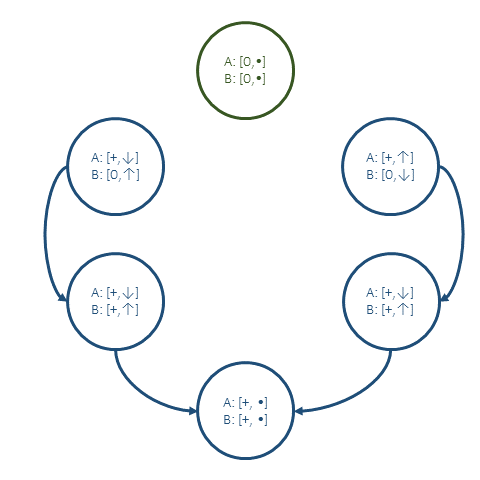

In [2]:
from IPython.display import Image
Image(filename='QSIM_1.png') 


### Solving with computer-aided methods

The above envisionment problem can also be solved algorithmically. A traditional approach would consist of establishing the geometry of the tanks, the relationship between the net flow rate and the pressure difference, and construct and simulate a corresponding differential equation. One can also do this without precise knowledge. One method is qualitative simulation (QSIM). An advantage is that the computed result is insensitive to the geometry of the tanks and the precise pressure-flow relationships. This makes for a simulation of system behaviour which can be extrapolated very far, naturally at the cost of a coarse description of the predicted behaviour. 

#### Specifying the model

##### Variables

Practically, the set of qualitative states can be obtained by solving a constraint satisfaction problem (CSP). To this end, the simulated variables or the tank levels ($h_A$ and $h_B$) as well as the difference in height ($\Delta$) and the net flow rate from tank A to tank B ($q$). A priori, the tank levels are allowed to be zero or positive. The change of direction for both tank levels is allowed to be zero, positive, or negative. The tank level difference and net flow rate are allowed to be zero, positive, or negative, as is the case for their change of direction. The following piece of code specifies the qualitative states that are considered feasible a priori. To this end, each feasible combination of the sign of a variable and its direction of change is given as a pair $(s,d)$ with $s$ the sign and $d$ the direction of change: 

In [3]:
# Problem description
problem = Problem()
problem.addVariable("hA", [(0,-1),(0,0),(0,+1),(+1,-1),(+1,0),(+1,+1)])
problem.addVariable("hB", [(0,-1),(0,0),(0,+1),(+1,-1),(+1,0),(+1,+1)])
problem.addVariable("Delta", [(0,-1),(0,0),(0,+1),(+1,-1),(+1,0),(+1,+1),(-1,-1),(-1,0),(-1,+1)])
problem.addVariable("q", [(0,1),(+1,1),(-1,1),(0,-1),(+1,-1),(-1,-1),(0,0),(+1,0),(-1,0)])

Without any constraints there would be 6x6x9x9=2916 feasible combinations for the signs and directions of change.

**Algebraic constraints**

Next, one adds the constraints that must hold between the signs and directions of change. The constraints that hold in this case are expressed in sign algebra. As an example, consider the algebraic equation between $\Delta$, $h_A$, and $h_B$. In a precise, quantitative setting one writes that:

$\Delta = h_A - h_B$

It follows also that

$\dot{\Delta} = \dot{h}_A - \dot{h}_B$

The equivalent equations for the sign of $\Delta$, $h_A$, and $h_B$ and their direction of change is written as:

* $[\Delta] = [h_A] - [h_B]$

* $[\dot{\Delta}] = [\dot{h}_A] - [\dot{h}_B]$

with $[h_A]$ meaning the sign of $h_A$ and $[\dot{h}_A]$ meaning the direction of change of $h_A$. These equations are described as qualitative algebraic equations.

The following value combinations constitute a solution that satisfies the above constraint:

$([\Delta],[\dot{\Delta}])=(+,\uparrow)$ ; $([h_A],[\dot{h}_A])=(+,\uparrow)$ ; $([h_B],[\dot{h}_B])=(+,\downarrow)$

Note that the signs of $\Delta$, $h_A$, and $h_B$ being simultaneously positive is indeed feasible. This however implies that $h_A$ is higher than $h_B$.

Another piece of information is that the flow rate is a strictly monotonic function of the level difference. One assumes no knowledge of the exact, quantitative equation describing this relationship however. This can expressed with the following implicit equation:

$M_o(q, \Delta)$

which says (a) that the flow $q$ (from A to B) is a monotonic relationship with the level difference $\Delta$ (between A and B) and (b) that either $q$ or $\Delta$  can be equal to zero only if both are equal to zero.

This relationship is written more explicitly as:

* $[q] = [\Delta]$

* $[\dot{q}] = [\dot{\Delta}]$


**Differential constraints**

The dynamics of the level in tank A can be written quantitatively as:

$\frac{dh_A}{dt} = -\frac{q}{S(h_A)}$

with $S(h_A)$ the cross-sectional area at the tank level. This can be abstracted into a simpler relationship in terms of signs and direction of change:

$\left[\dot{h}_A\right] = -[q]$

which says that the tank level A will stay/decrease/increase if the net flow rate is zero/positive/negative. Note that cross-sectional area has disappeared from the equation as it is always positive.

Similarly, the direction of change of tank level B must satisfy:

$\left[\dot{h}_B\right] = [q]$

**Complete set of constraints**

The next piece of code adds the following constraints to the CSP:

* $[\Delta] = [h_A] - [h_B]$

* $[\dot{\Delta}] = [\dot{h}_A] - [\dot{h}_B]$

* $[q] = [\Delta]$

* $[\dot{q}] = [\dot{\Delta}]$

* $\left[\dot{h}_A\right] = -[q]$

* $\left[\dot{h}_B\right] = [q]$

In [4]:
problem.addConstraint(lambda p1, p2, dp: fProductSum([+1,-1,-1],[p1, p2, dp]),("hA","hB","Delta"))
problem.addConstraint(lambda p, q: fIsotone0(p,q),("Delta", "q"))
problem.addConstraint(lambda p, q: fDifferential(p,q,-1),("hA", "q"))
problem.addConstraint(lambda p, q: fDifferential(p,q,+1),("hB", "q"))

#### Identifying the qualitative states

Finally, we solve the constraint satisfaction problem and list all feasible qualitative states. In the printed results below each variable described with a pair of values reflecting the sign of the variable (0, +, or -) and the direction of change ($\cdot$, $\uparrow$, or $\downarrow$).

In [5]:
solutions = problem.getSolutions()
solutions_as_text = printsolutions(solutions);

In [6]:
[print(t,solutions_as_text[t]) for t in solutions_as_text];

0 q: [0,•]; Delta: [0,•]; hA: [+,•]; hB: [+,•]; 
1 q: [0,•]; Delta: [0,•]; hA: [0,•]; hB: [0,•]; 
2 q: [+,↓]; Delta: [+,↓]; hA: [+,↓]; hB: [+,↑]; 
3 q: [+,↓]; Delta: [+,↓]; hA: [+,↓]; hB: [0,↑]; 
4 q: [-,↑]; Delta: [-,↑]; hA: [+,↑]; hB: [+,↓]; 
5 q: [-,↑]; Delta: [-,↑]; hA: [0,↑]; hB: [+,↓]; 


One can verify easily that the six solutions correspond to the six qualitative states obtained earlier through human reasoning. This computer-based solution is obtained with a backtracking solver. 

Importantly, the computed-based solution is obtained in absence of a precise, quantitative model, as is typical for human reasoning. It is however unlikely that the human reasoning process makes use of the same algorithm/solver to find these solutions. In recent research, it has been suggested that human reasoning relies primarily on the application of analogies [[8]](https://mitpress.mit.edu/books/qualitative-representations).

#### Envisionment

Once all feasible qualitative states are computed, one needs to verify which qualitative states can follow each other. For systems that are (at least) first-order continuous, one state can follow another one only if the following rules are adhered to:

* A direct change of sign between positive (+) and negative (-) in one step is infeasible - it must go through zero (0) in between (C0 continuity).
* A direct change of direction of change between upward ($\uparrow$) and downward ($\downarrow$) in one step is infeasible - it must go through steady ($\cdot$) in between (C1 continuity).
* If the sign of a variable is zero (0) and its direction is non-steady ($\uparrow$ or $\downarrow$), then the system will leave this state immediately. In other words, the system cannot stay in this state.

The possible sequences of qualitative states are represented by a mathematical graph. In this directed graph, nodes represent the qualitative states and edges represent the connections between them. 

The next piece of code computes the connectivity matrix. This matrix is composed of zeros and ones. A one is placed in the row-column position (s,t) if the qualitative state with index $s$ can be followed by the qualitative state with index $t$. There are two states (index 3 and 5, row/column 4 and 6) that are left immediately upon reaching them, as is evident from the corresponding zero-valued diagonal element. The other states do not exhibit this property, meaning that the system can stay in this state during a non-empty time interval. In graph-theoretical terms, this means an edge  exists from this node to itself (self-loop).

In [7]:
A = fGraph(solutions) 
print(A)

[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]]


The next piece of code vizualizes the graph. Terminal, final states are shown with a black circle (State 0 and 1). Once this state is reached, the system will stay there forever The system states that can persist for a non-tempty time interval have self-loops and are shown as a filled circle (0, 1, 2, 4). The other states have no self-loops and must be left immediately and are shown as empty (3, 5). 

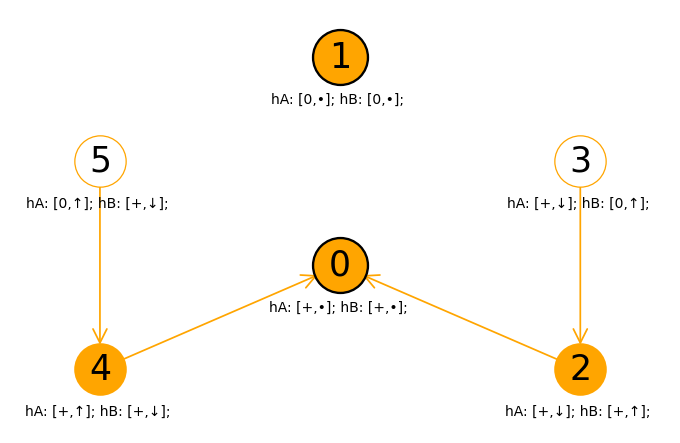

In [8]:
I = len(solutions)
XY = np.random.randn(I,2)

for i in range(I):
    sol = solutions[i] ;
    P1 = sol['hA'][0]
    dP1 = sol['hA'][1] 
    P2 = sol['hB'][0]
    dP2 = sol['hB'][1]  
    XY[i,:] = [(-dP1+dP2), -P1*P2 -((-dP1+dP2)/2)**2/2]; 
    pass    

text= printsolutions([{'hA':sol['hA'],'hB':sol['hB']} for sol in solutions])
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(3,2),dpi=250)
plotGraph(A,solutions,ax=ax,XY=XY,description=text,offset=1/6)   

## A slightly more complex example

A slightly more complex behavior is obtained by qualitative simulation of three tanks in series (A, B, and C), where A drains into tank B and tank B drains into tank C. We make similar assumptions (zero or positive tank levels, no overflow). The next piece of code shows how the CSP is defined. This now involves three tank levels ($h_A$, $h_B$, $h_C$), two net flow rates ($q_{AB}$, $q_{BC}$), and the net flow rate to tank B ($q_{B,net}$).

In [9]:
problem = Problem()
problem.addVariable("hA", [(0,-1),(0,0),(0,+1),(+1,-1),(+1,0),(+1,+1)])
problem.addVariable("hB", [(0,-1),(0,0),(0,+1),(+1,-1),(+1,0),(+1,+1)])
problem.addVariable("hC", [(0,-1),(0,0),(0,+1),(+1,-1),(+1,0),(+1,+1)]) 
problem.addVariable("qAB", [(0,1),(+1,1),(-1,1),(0,-1),(+1,-1),(-1,-1),(0,0),(+1,0),(-1,0)])
problem.addVariable("qBC", [(0,1),(+1,1),(-1,1),(0,-1),(+1,-1),(-1,-1),(0,0),(+1,0),(-1,0)])
problem.addVariable("qBnet", [(0,1),(+1,1),(-1,1),(0,-1),(+1,-1),(-1,-1),(0,0),(+1,0),(-1,0)])
problem.addConstraint(lambda q12, q23, q: fProductSum([+1,-1,-1],[q12, q23, q]),("qAB","qBC","qBnet"))
problem.addConstraint(lambda p, q: fIsotone0(p,q),("hA", "qAB"))
problem.addConstraint(lambda p, q: fIsotone0(p,q),("hB", "qBC"))
problem.addConstraint(lambda p, q: fDifferential(p,q,-1),("hA", "qAB"))
problem.addConstraint(lambda p, q: fDifferential(p,q,+1),("hB", "qBnet"))
problem.addConstraint(lambda p, q: fDifferential(p,q,+1),("hC", "qBC"))

Next, we solve the CSP:

In [10]:
solutions = problem.getSolutions() 
solutions_as_text = printsolutions(solutions);
[print(t,solutions_as_text[t]) for t in solutions_as_text];

0 qAB: [0,•]; qBC: [0,•]; hA: [0,•]; hB: [0,•]; qBnet: [0,•]; hC: [+,•]; 
1 qAB: [0,•]; qBC: [0,•]; hA: [0,•]; hB: [0,•]; qBnet: [0,•]; hC: [0,•]; 
2 qAB: [0,•]; qBC: [+,↓]; hA: [0,•]; hB: [+,↓]; qBnet: [-,↑]; hC: [+,↑]; 
3 qAB: [0,•]; qBC: [+,↓]; hA: [0,•]; hB: [+,↓]; qBnet: [-,↑]; hC: [0,↑]; 
4 qAB: [+,↓]; qBC: [+,•]; hA: [+,↓]; hB: [+,•]; qBnet: [0,↓]; hC: [+,↑]; 
5 qAB: [+,↓]; qBC: [+,•]; hA: [+,↓]; hB: [+,•]; qBnet: [0,↓]; hC: [0,↑]; 
6 qAB: [+,↓]; qBC: [+,↓]; hA: [+,↓]; hB: [+,↓]; qBnet: [-,•]; hC: [+,↑]; 
7 qAB: [+,↓]; qBC: [+,↓]; hA: [+,↓]; hB: [+,↓]; qBnet: [-,•]; hC: [0,↑]; 
8 qAB: [+,↓]; qBC: [+,↓]; hA: [+,↓]; hB: [+,↓]; qBnet: [-,↑]; hC: [+,↑]; 
9 qAB: [+,↓]; qBC: [+,↓]; hA: [+,↓]; hB: [+,↓]; qBnet: [-,↑]; hC: [0,↑]; 
10 qAB: [+,↓]; qBC: [+,↓]; hA: [+,↓]; hB: [+,↓]; qBnet: [-,↓]; hC: [+,↑]; 
11 qAB: [+,↓]; qBC: [+,↓]; hA: [+,↓]; hB: [+,↓]; qBnet: [-,↓]; hC: [0,↑]; 
12 qAB: [+,↓]; qBC: [+,↑]; hA: [+,↓]; hB: [+,↑]; qBnet: [+,↓]; hC: [+,↑]; 
13 qAB: [+,↓]; qBC: [+,↑]; hA: [+,↓

There are 16 unique solutions. Could a human come up with this complete list? I think yes, but maybe it is not as trivial as one might think. We can compute the connectivity matrix again and show the resulting graph with sign and direction of change indicated for $h_A$, $h_B$, $h_C$, and $q_{B,net}$.

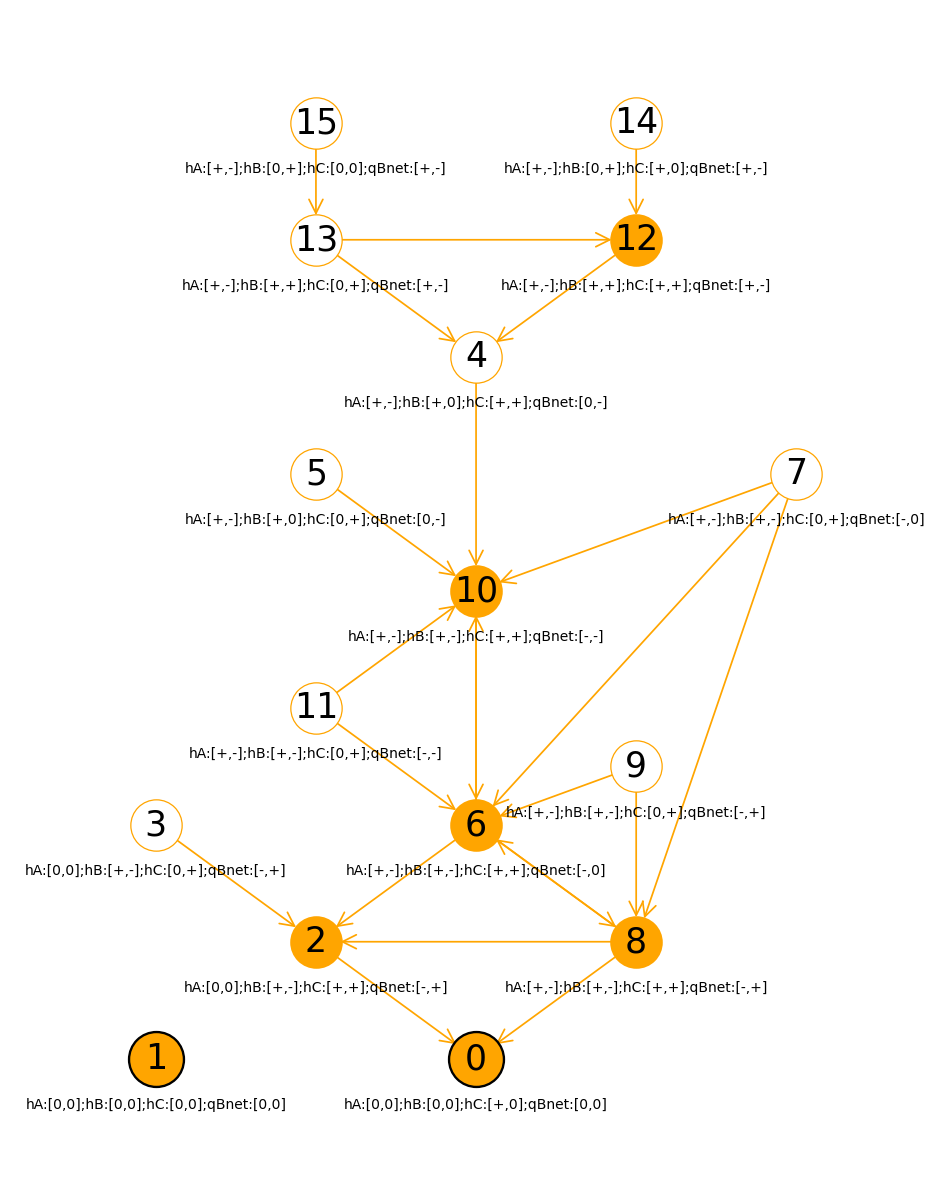

In [11]:
A = fGraph(solutions)
I = len(solutions)
XY = np.zeros([I,2])
XY[0,:] = [-1,+6] ;
XY[1,:] = [-3,+6] ;
XY[2,:] = [-2,+7] ;
XY[3,:] = [-3,8] ;
XY[4,:] = [-1,12] ;
XY[5,:] = [-2,11] ;
XY[6,:] = [-1,8] ;
XY[7,:] = [1,11] ;
XY[8,:] = [0,+7] ;
XY[9,:] = [0,8.5] ;
XY[10,:] = [-1,10] ;
XY[11,:] = [-2,9] ; 
XY[12,:] = [0,13] ; 
XY[13,:] = [-2,13] ; 
XY[14,:] = [0,14] ; 
XY[15,:] = [-2,14] ; 
description = dict()
for i in range(I):
    sol = solutions[i] ;
    hA = sol['hA'][0]
    hA1 = sol['hA'][1]
    hB = sol['hB'][0]
    dhB = sol['hB'][1]
    hC = sol['hC'][0]
    dhC = sol['hC'][1]
    qBnet = sol['qBnet'][0]
    dqBnet = sol['qBnet'][1]
    label = 'hA:['+sign2str(hA)+','+sign2str(hA1)+'];hB:['+sign2str(hB)+','+sign2str(dhB)+'];hC:['+sign2str(hC)+','+sign2str(dhC)+'];qBnet:['+sign2str(qBnet)+','+sign2str(dqBnet)+']'
    description[i] = label
    pass    

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(4,6),dpi=250)
plotGraph(A,solutions,ax=ax,XY=XY,description=description,offset=1/3)  

This is clearly a more complex graph. There are again two terminal states (0: all liquid in tank C; 1: no liquid present). Even though the 3-tank problem conceptually very simple, it allows for a rich set of qualitatively distinct system states. 

## Take home message

* Qualitative simulation (QSIM) can be used to describe dynamic behavior of systems for which a detailed quantitative model is not available. 

* I demonstrated QSIM with some simple examples

* QSIM and the related subject of qualitative reasoning is very much a niche subject. I think it carries quite some potential however, some of which I hope to help uncover in the future.

## References

[1] De Kleer, J., & Brown, J. S. (1984). A qualitative physics based on confluences. Artificial intelligence, 24(1-3), 7-83. [[publisher]](https://doi.org/10.1016/0004-3702(84)90037-7)

[2] Forbus, K. (1984). Qualitative Process Theory. Artificial Intelligence, 24, 85-168. [[publisher]](https://doi.org/10.1016/0004-3702(84)90038-9)

[3] Kuipers, B. (1986). Qualitative simulation. Artificial intelligence, 29(3), 289-338. [[publisher]](https://doi.org/10.1016/0004-3702(86)90073-1)

[4] Kuipers, B. (1994).  Qualitative Reasoning - Modeling and Simulation with Incomplete Knowledge. MIT Press, Cambridge, MA, USA. [[publisher]](https://mitpress.mit.edu/books/qualitative-reasoning)

[5] Bredeweg, B., Linnebank, F., Bouwer, A., & Liem, J. (2009). Garp3 — Workbench for qualitative modelling and simulation. Ecological informatics, 4(5-6), 263-281. [[publisher]](https://doi.org/10.1016/j.ecoinf.2009.09.009)

[6] Bredeweg, B., & Forbus, K. D. (2003). Qualitative modeling in education. AI magazine, 24(4), 35-35. [[publisher]](https://doi.org/10.1609/aimag.v24i4.1729)

[7] Sacks, E. P., & Doyle, J. (1992). Prolegomena to any future qualitative physics. Computational Intelligence, 8(2), 187-209. [[publisher]](https://doi.org/10.1111/j.1467-8640.1992.tb00344.x)

[8] Forbus, K. D. (2019). Qualitative representations: How people reason and learn about the continuous world. MIT Press, Cambridge, MA, USA. [[publisher]](https://mitpress.mit.edu/books/qualitative-representations)